In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ---------- CONFIG ----------
DATA_PATH = "customer_churn_dataset-training-Dataset.csv"
OUTPUT_DIR = "models_output"
RANDOM_STATE = 42
TEST_SIZE = 0.25
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# ---------- 1) LOAD DATA ----------
df = pd.read_csv(DATA_PATH)
print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns")

Loaded 440833 rows and 12 columns


In [4]:
# ---------- 2) BASIC EDA ----------
print("\n=== Missing Value Summary ===")
print(df.isnull().sum())

print("\n=== Data Types ===")
print(df.dtypes.value_counts())


=== Missing Value Summary ===
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

=== Data Types ===
float64    9
object     3
Name: count, dtype: int64


In [5]:
# Visualize class imbalance if churn column exists
sns.set(style="whitegrid")
plt.figure(figsize=(8,4))
target_candidates = [c for c in df.columns if any(k in c.lower() for k in ['churn','exited','attrition','target','label'])]
if target_candidates:
    tgt = target_candidates[0]
    sns.countplot(x=tgt, data=df)
    plt.title("Target Class Distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "class_balance.png"))
    plt.close()

In [6]:
# ---------- 3) TARGET SELECTION ----------
candidates = [c for c in df.columns if any(k in c.lower() for k in ['churn','exited','attrition','target','label'])]
binary_cols = [c for c in df.columns if df[c].nunique(dropna=False)==2]
non_id_binary = [c for c in binary_cols if not any(idk in c.lower() for idk in ['id','customer','cust','account','ref'])]
if candidates:
    target_col = candidates[0]
elif non_id_binary:
    target_col = non_id_binary[0]
else:
    target_col = df.columns[-1]

print(f"\nSelected Target Column: {target_col}")
print(df[target_col].value_counts(dropna=False))


Selected Target Column: Churn
Churn
1.0    249999
0.0    190833
NaN         1
Name: count, dtype: int64


In [7]:

# ---------- 4) CLEANING ----------
df = df[~df[target_col].isnull()].copy()
unique_counts = df.nunique()
id_like = unique_counts[unique_counts == df.shape[0]].index.tolist()
df = df.drop(columns=id_like, errors='ignore')

In [8]:
# ---------- 5) SPLIT ----------
X = df.drop(columns=[target_col])
y = df[target_col].copy()

In [9]:
# Map categorical target
if y.dtype == object or y.dtype.name == 'category':
    vals = y.unique().tolist()
    mapping = {v: (1 if str(v).lower() in ['yes','y','churned','true','1'] else 0) for v in vals}
    y = y.map(mapping)
else:
    if y.nunique() > 2:
        y = (y > y.median()).astype(int)

In [10]:
# ---------- 6) FEATURE ENGINEERING ----------
# Example: Add average charges per month, tenure group
if 'Tenure' in X.columns and 'MonthlyCharges' in X.columns:
    X['AvgChargesPerTenure'] = X['MonthlyCharges'] / (X['Tenure'] + 1)
if 'Tenure' in X.columns:
    X['TenureGroup'] = pd.cut(X['Tenure'], bins=[0,12,24,48,72,120], labels=['<1yr','1-2yrs','2-4yrs','4-6yrs','6+yrs'])

In [11]:
# ---------- 7) PREPROCESS ----------
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

num_imputer = SimpleImputer(strategy='median')
if num_cols:
    X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols)
else:
    X_num = pd.DataFrame(index=X.index)

In [12]:
# Categorical encoding
TOP_N = 20
if cat_cols:
    X_cat = X[cat_cols].copy()
    for c in cat_cols:
        # Add 'Missing' to categories before filling NaN
        if pd.api.types.is_categorical_dtype(X_cat[c]):
            X_cat[c] = X_cat[c].cat.add_categories('Missing')
        else:
             X_cat[c] = X_cat[c].astype('category').cat.add_categories('Missing')

        X_cat[c] = X_cat[c].fillna('Missing')

        top = X_cat[c].value_counts().index[:TOP_N]
        X_cat[c] = X_cat[c].where(X_cat[c].isin(top), other='OTHER')

    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_cat_enc = pd.DataFrame(oe.fit_transform(X_cat), columns=cat_cols)
else:
    X_cat_enc = pd.DataFrame(index=X.index)

X_proc = pd.concat([X_num.reset_index(drop=True), X_cat_enc.reset_index(drop=True)], axis=1)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_proc), columns=X_proc.columns)

In [13]:
# ---------- 8) SPLIT TRAIN/TEST ----------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE, stratify=y)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 330624, Test size: 110208


In [14]:
# ---------- 9) TRAIN BASELINE MODELS ----------
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
}
trained, results = {}, []
for name, model in models.items():
    model.fit(X_train, y_train)
    trained[name] = model
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]
    res = {
        "model": name,
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, probs)
    }
    results.append(res)

results_df = pd.DataFrame(results).round(4)
print("\n=== Baseline Model Results ===")
print(results_df)


=== Baseline Model Results ===
                model  accuracy  precision  recall      f1  roc_auc
0  LogisticRegression    0.8513     0.8792  0.8552  0.8670   0.9284
1        RandomForest    0.9998     1.0000  0.9996  0.9998   1.0000


In [17]:
# ---------- 10) MODEL TUNING ----------
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

print("\n🔧 Step 10: Tuning RandomForest with GridSearchCV...")

# Define parameters safely (can adjust if needed)
RANDOM_STATE = 42
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

# Initialize GridSearchCV
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid.fit(X_train, y_train)

# Best estimator
best_rf = grid.best_estimator_
print("\n✅ Best RandomForest Parameters Found:")
print(grid.best_params_)

# Evaluate tuned model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("\nClassification Report (Tuned RandomForest):")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

roc_auc = roc_auc_score(y_test, y_prob_rf)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Save tuned model
import joblib, os
os.makedirs("models_output", exist_ok=True)
joblib.dump(best_rf, "models_output/Best_RandomForest.joblib")
print("\n💾 Tuned RandomForest model saved as 'models_output/Best_RandomForest.joblib'")



🔧 Step 10: Tuning RandomForest with GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Best RandomForest Parameters Found:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

Classification Report (Tuned RandomForest):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     47708
         1.0       1.00      1.00      1.00     62500

    accuracy                           1.00    110208
   macro avg       1.00      1.00      1.00    110208
weighted avg       1.00      1.00      1.00    110208

Confusion Matrix:
[[47705     3]
 [   24 62476]]
ROC-AUC Score: 1.0000

💾 Tuned RandomForest model saved as 'models_output/Best_RandomForest.joblib'



--- Step 11: Customer Segmentation using K-Means ---


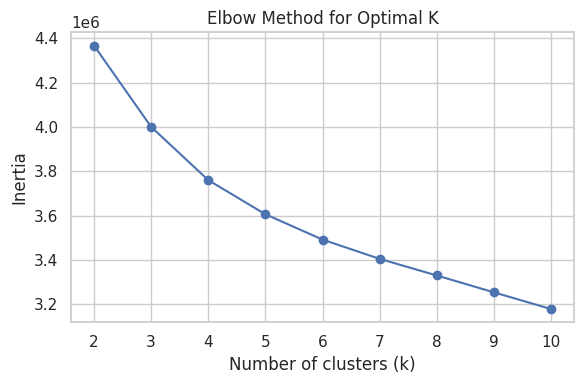

In [20]:
# ---------- 11) CUSTOMER SEGMENTATION (K-MEANS) ----------
print("\n--- Step 11: Customer Segmentation using K-Means ---")

# Use the same scaled features for clustering
inertia = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "elbow_method.png"))
plt.show()

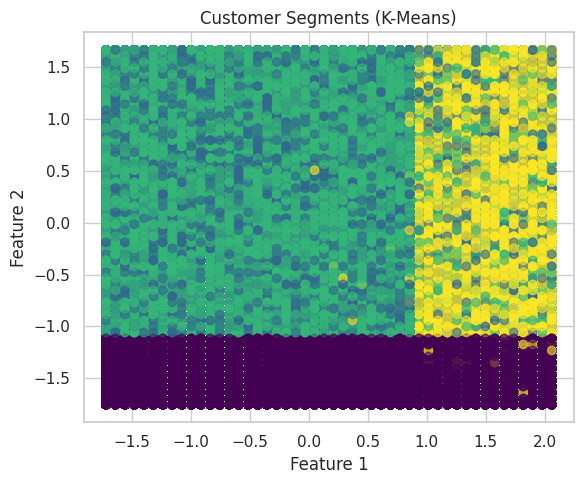

Step 11 complete — clustering results saved in 'models_output'.

Pipeline finished successfully ✅


In [28]:
# Visualize clusters (first two PCA-like features)
plt.figure(figsize=(6,5))
plt.scatter(X_scaled.iloc[:,0], X_scaled.iloc[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("Customer Segments (K-Means)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "kmeans_clusters.png"))
plt.show()

print("Step 11 complete — clustering results saved in 'models_output'.")

# ================================================================
print("\nPipeline finished successfully ✅")
# ================================================================


--- Step 12: Cluster-level Churn Visualization ---

Average Churn Rate per Cluster:
 Cluster
0    0.584822
1    0.497892
2    0.305679
3    0.995943
Name: Churn, dtype: float64


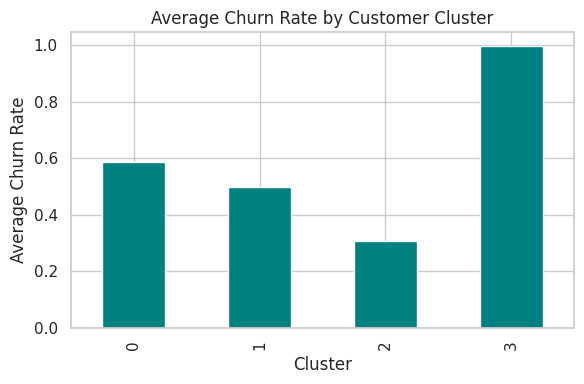

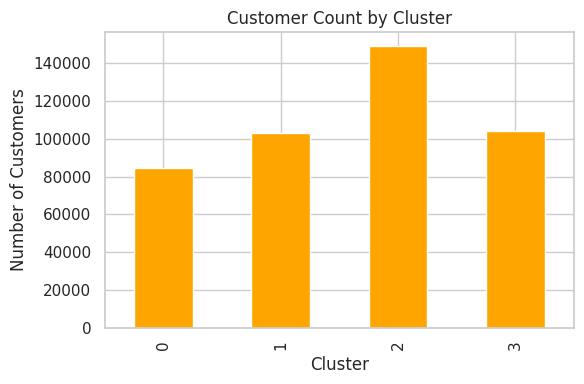

Step 12 completed — cluster churn insights visualized and saved.


In [29]:
# ---------- 12) CLUSTER-LEVEL CHURN INSIGHTS & VISUALIZATION ----------
print("\n--- Step 12: Cluster-level Churn Visualization ---")

# Ensure cluster and target are aligned
if 'Cluster' in df.columns:
    df['Churn'] = y.values  # reattach churn target if needed

    # Average churn rate by cluster
    churn_by_cluster = df.groupby('Cluster')['Churn'].mean().sort_index()
    print("\nAverage Churn Rate per Cluster:\n", churn_by_cluster)

    plt.figure(figsize=(6,4))
    churn_by_cluster.plot(kind='bar', color='teal')
    plt.title("Average Churn Rate by Customer Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Average Churn Rate")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "churn_by_cluster.png"))
    plt.show()

    # Cluster size visualization
    cluster_sizes = df['Cluster'].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    cluster_sizes.plot(kind='bar', color='orange')
    plt.title("Customer Count by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Customers")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "cluster_sizes.png"))
    plt.show()

    print("Step 12 completed — cluster churn insights visualized and saved.")
else:
    print("⚠️ Cluster data not found. Please run Step 11 first.")

In [31]:
# ---------- 13) DEMO PREDICTION ----------
print("\n--- Step 13: Demo Prediction using Tuned RandomForest ---")
loaded_model = joblib.load(os.path.join(OUTPUT_DIR, "Best_RandomForest.joblib"))

# Take one sample from test data
sample = X_test.iloc[[0]]
pred = loaded_model.predict(sample)[0]
proba = loaded_model.predict_proba(sample)[0][1]
print(f"Predicted Churn: {pred} (Probability: {proba:.3f})")


--- Step 13: Demo Prediction using Tuned RandomForest ---
Predicted Churn: 0.0 (Probability: 0.010)


In [32]:
print(" \nPipeline completed successfully.")

 
Pipeline completed successfully.
